# Softmax Regression Implementation from Scratch

Because **softmax regression is so fundamental**,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [1]:
import torch
from d2l import torch as d2l

## The Softmax

Let's begin with the most important part:
the mapping from scalars to probabilities.
For a refresher, recall the operation of the sum operator
along specific dimensions in a tensor,
as discussed in :numref:`subsec_lin-alg-reduction`
and :numref:`subsec_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis.**]
The `axis` variable lets us compute row and column sums:


In [2]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

Computing the softmax requires three steps:
(i) exponentiation of each term;
(ii) a sum over each row to compute the normalization constant for each example;
(iii) division of each row by its normalization constant,
ensuring that the result sums to 1:

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The (logarithm of the) denominator
is called the (log) *partition function*.
It was introduced in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
to sum over all possible states in a thermodynamic ensemble.
The implementation is straightforward:


In [3]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any input `X`, [**we turn each element
into a nonnegative number.
Each row sums up to 1,**]
as is required for a probability. Caution: the code above is *not* robust against very large or very small arguments. While it is sufficient to illustrate what is happening, you should *not* use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.


> ✨✨✨
> The caution is real. **When exponentiating the large values, it will create an underflow or overflow. The libraries manage them by the following**:

---

The caution about the softmax implementation being "not robust against very large or very small arguments" refers to a common numerical instability problem. Here's why that happens and how deep learning libraries handle it:

### **Numerical Instability Problem**:
When the logits (raw outputs, `X`) are too large or too small, exponentiating them (`exp(X)`) can lead to numerical issues:
1. **Large values**: Exponentiating very large numbers (e.g., `exp(1000)`) can result in overflow, producing infinity.
2. **Small values**: Exponentiating very negative numbers (e.g., `exp(-1000)`) can underflow, resulting in values that are practically zero.

These extreme numbers can lead to inaccurate computations or even crashes when used in further steps like division or loss computation.

### **How Libraries Handle It**:
Deep learning libraries like PyTorch and TensorFlow have built-in solutions to prevent this from happening. The most common approach is **log-sum-exp trick**, which prevents overflow or underflow by normalizing the logits before applying the softmax.

#### **Log-Sum-Exp Trick**:
Instead of computing the softmax directly as:
$$
\text{softmax}(X_i) = \frac{\exp(X_i)}{\sum_j \exp(X_j)}
$$
They stabilize the calculation by subtracting the maximum value of `X` from all logits before applying softmax:
$$
\text{softmax}(X_i) = \frac{\exp(X_i - \max(X))}{\sum_j \exp(X_j - \max(X))}
$$
This subtraction doesn't change the result of the softmax, but it ensures that the largest number in `X` becomes 0, and the others are negative, keeping the exponentials within a manageable range.

### **Why It Works**:
- **Large values**: Subtracting the max value from each logit keeps the exponentiated terms from blowing up to infinity.
- **Small values**: Even very negative numbers after the subtraction become close to zero, avoiding underflow issues.

### Example:
Imagine `X = [1000, 999, 998]`. Directly applying softmax would result in overflow. But by subtracting the max value (1000), we get `[0, -1, -2]`. Exponentiating these numbers gives more manageable values `[1, 0.3679, 0.1353]`, which can then be normalized correctly.

In practice, most deep learning frameworks like PyTorch (`torch.nn.functional.softmax`) or TensorFlow (`tf.nn.softmax`) implement this trick automatically, ensuring that softmax computations are stable even with extreme logits.
not use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.

---

Does that look cool!?

In [4]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1672, 0.1325, 0.1620, 0.2171, 0.3212],
         [0.2032, 0.1771, 0.2251, 0.1580, 0.2366]]),
 tensor([1., 1.]))

## The Model

In [5]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

The code below defines how the network
maps each input to an output.
Note that we flatten each $28 \times 28$ pixel image in the batch
into a vector using `reshape`
before passing the data through our model.


In [6]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

## The Cross-Entropy Loss

In [7]:
y = torch.tensor([0, 2]) # the index of true labels to "pick out" the predicted probs
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] # the predicted probs

tensor([0.1000, 0.5000])

Now we can (**implement the cross-entropy loss function**) by averaging over the logarithms of the selected probabilities.


In [8]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

# The above has done the following:

1. `[0.1000, 0.5000]`
2. `log([0.1000, 0.5000])`
3. `log([0.1000, 0.5000]).sum()`

In [9]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

In [10]:
data = d2l.FashionMNIST(batch_size=256)

In [11]:
sample_data = next(iter(data.train_dataloader()))

In [12]:
sample_data[0].shape, sample_data[1].shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

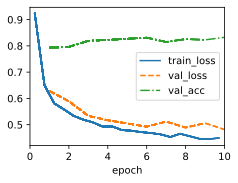

In [13]:
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [14]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

In [15]:
preds

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 7, 7, 7,
        1, 2, 6, 0, 9, 4, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 0, 9, 6, 7, 2, 1,
        2, 6, 2, 2, 5, 6, 2, 2, 8, 2, 8, 0, 7, 7, 8, 5, 1, 1, 0, 4, 7, 8, 7, 0,
        6, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 3, 6, 7, 1, 8,
        0, 1, 6, 2, 3, 4, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 2, 1, 5, 4, 1, 9, 1, 8, 4, 2, 1, 2, 5, 1, 0, 0, 0,
        1, 6, 1, 3, 2, 2, 6, 2, 1, 3, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
        4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 8, 7, 9, 9, 4, 4, 7, 1, 2,
        1, 2, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 2, 7, 4, 8, 5, 3, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2,
        5, 4, 9, 6, 2, 8, 6, 2, 2, 4, 9, 7, 4, 5, 5, 2])

We are more interested in the images we label *incorrectly*. We visualize them by
comparing their actual labels
(first line of text output)
with the predictions from the model
(second line of text output).


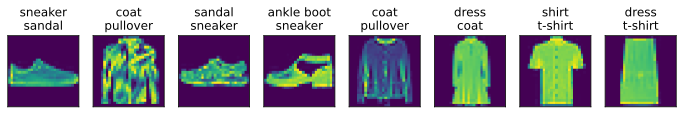

In [16]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

# ✨ Well, I ***hate it*** when it feels like a magic ✨

Let's calculate the stuff by our own.

- Yes, we will train on training data and test in validation dataset
- We will create our own classifier in the cells as well.

Let's do that. I will copy over some of the code from **linear regression** but most of them will feel similar as we get along.

In [17]:
total_epochs = 20
validate_at = 3

In [18]:
data = d2l.FashionMNIST(batch_size=256, resize=(28, 28))

In [19]:
data.train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

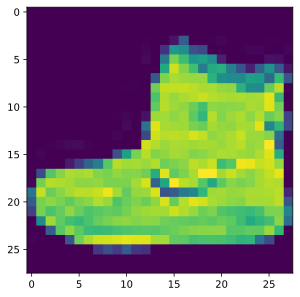

In [20]:
import matplotlib.pyplot as plt
plt.imshow(data.train[0][0].squeeze(0));

In [21]:
train_iter = iter(data.train_dataloader())
val_iter = iter(data.val_dataloader())

In [22]:
def give_batch(train):
    if train: # give a random batch
        X, y = next(train_iter)
    else:
        X, y = next(val_iter)
    return X, y

In [23]:
# get initial batch
X, y = give_batch(train=True)

In [24]:
# STEP - 1: initializing weights that will be trained
num_inputs = 28 * 28
num_outputs = 10

weights = torch.randn(num_inputs, num_outputs, requires_grad=True)
bias = torch.randn(num_outputs, requires_grad=True)

In [25]:
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

In [26]:
X.shape

torch.Size([256, 1, 28, 28])

In [27]:
X.reshape(-1, weights.shape[0]).shape

torch.Size([256, 784])

In [28]:
# STEP - 2: forward pass
prediction = torch.matmul(X.reshape(-1, weights.shape[0]), weights) + bias

In [29]:
# initial prediction
prediction, prediction.shape

(tensor([[-35.2190,  -2.4185, -29.3364,  ...,  27.8235,  17.2912,  -0.1082],
         [-10.3221,  -1.7248,  11.8993,  ..., -19.3876,   3.2500,  -0.2560],
         [-18.3860,  -1.6841, -38.5062,  ...,  11.1814,  11.4696,  14.4264],
         ...,
         [-45.3418,   5.6846, -13.3679,  ...,  18.7804,  12.8517,   2.1063],
         [-31.9633,  -2.3409, -25.5813,  ...,  15.5810,   9.1215,  -1.9185],
         [-14.5656,   1.2586, -27.5553,  ...,  10.8630,   7.5396,  16.6745]],
        grad_fn=<AddBackward0>),
 torch.Size([256, 10]))

> 🔥🔥 The above are the initial logits. We will need **to apply the softmax here** to get the probabilities.

In [30]:
# The same
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [31]:
# STEP - 3: Getting the probabilities
prediction_prob = softmax(prediction)

In [32]:
# STEP - 4: Cross entropy (loss)
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [33]:
loss = cross_entropy(prediction_prob, y)
loss

tensor(19.7617, grad_fn=<NegBackward0>)

In [34]:
# currently we don't have any grad
type(weights.grad)

NoneType

In [35]:
# STEP - 5: Calculate the grad
loss.backward()

In [36]:
# now we have the grad!
type(weights.grad), weights.grad

(torch.Tensor,
 tensor([[ 1.9244e-13,  2.9292e-08, -1.5319e-05,  ...,  9.1496e-08,
           1.4441e-05,  5.3439e-07],
         [-4.5956e-05,  3.7740e-19,  1.4978e-35,  ...,  9.4577e-20,
           7.6488e-15,  7.1450e-15],
         [-1.5319e-05,  2.3360e-10,  4.2049e-19,  ...,  1.3765e-09,
          -9.0355e-06,  9.0319e-06],
         ...,
         [-6.1269e-05,  4.2975e-04,  1.2274e-05,  ...,  1.7214e-05,
          -7.5805e-04,  4.1479e-03],
         [ 7.2422e-12,  2.4504e-05,  2.1302e-12,  ...,  3.9435e-06,
           3.1398e-04,  2.3086e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]))

> The above grad are the the un-trained and initial grad... which we will update.

In [37]:
# STEP - 5: Update the weights
# old weights
weights

tensor([[-0.5078, -0.3761, -0.0585,  ..., -2.0050,  1.0394, -0.3830],
        [ 1.1520,  0.2780,  0.7032,  ..., -0.1974, -0.8903, -1.7603],
        [-0.9242, -1.4714, -0.3284,  ...,  0.6060, -0.2068,  0.1036],
        ...,
        [ 0.1804,  0.5947,  0.9383,  ...,  0.8454,  0.5531,  0.1684],
        [ 2.2163,  0.4720,  1.0713,  ..., -0.3804,  0.3950,  1.9138],
        [-0.2561, -0.6071,  1.3121,  ...,  0.0155,  0.7799,  1.3262]],
       requires_grad=True)

In [38]:
# updated weights
learning_rate = 0.1
with torch.no_grad(): # this is needed
    weights -= learning_rate * weights.grad
    bias -= learning_rate * bias.grad

In [39]:
# new weights
weights

tensor([[-0.5078, -0.3761, -0.0585,  ..., -2.0050,  1.0393, -0.3830],
        [ 1.1520,  0.2780,  0.7032,  ..., -0.1974, -0.8903, -1.7603],
        [-0.9242, -1.4714, -0.3284,  ...,  0.6060, -0.2068,  0.1036],
        ...,
        [ 0.1804,  0.5946,  0.9383,  ...,  0.8454,  0.5531,  0.1680],
        [ 2.2163,  0.4720,  1.0713,  ..., -0.3804,  0.3949,  1.9138],
        [-0.2561, -0.6071,  1.3121,  ...,  0.0155,  0.7799,  1.3262]],
       requires_grad=True)

In [40]:
# STEP - 6: reset the grad
if weights.grad is not None:
    print("ZEROED")
    weights.grad.zero_()

if bias.grad is not None:
    print("ZEROED")
    bias.grad.zero_()

ZEROED
ZEROED


Done! Now just run this in a loop until we get our loss to some acceptable level!

In [41]:
from tqdm.notebook import tqdm

In [42]:
# Max iterations
60000/256

234.375

In [43]:
## The epochs
learning_rate = 0.1
losses = []
for epoch in tqdm(range(20)):
    train_iter = iter(data.train_dataloader())
    val_iter = iter(data.val_dataloader())
    for i in range(230):
        X, y = next(train_iter)
        prediction = torch.matmul(X.reshape(-1, weights.shape[0]), weights) + bias
        prediction_prob = softmax(prediction)
        
        loss = cross_entropy(prediction_prob, y)
        losses.append(loss.item())
    
        if weights.grad is not None:
            weights.grad.zero_()
        
        if bias.grad is not None:
            bias.grad.zero_()
    
        with torch.no_grad(): # this is needed
            loss.backward()
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad
    
    print(epoch, losses[-1])
print(loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

0 2.528925657272339
1 1.7108041048049927
2 1.2044529914855957
3 1.3416846990585327
4 1.3132606744766235
5 1.1702289581298828
6 0.8251733779907227
7 1.0034475326538086
8 0.923997163772583
9 0.8747748136520386
10 0.8577374219894409
11 1.2147743701934814
12 0.8434361815452576
13 0.716874897480011
14 0.8452109098434448
15 1.0454667806625366
16 0.9002187252044678
17 0.7797236442565918
18 0.9625252485275269
19 0.8268448114395142
0.8268448114395142


In [44]:
## A RANDOM PREDICTION ##
X, y = give_batch(train=False)

In [45]:
prediction = torch.matmul(X.reshape(-1, weights.shape[0]), weights) + bias
prediction_prob = softmax(prediction)

In [46]:
y_hat = torch.argmax(prediction_prob, 1)
y_hat

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 9, 8, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 7,
        1, 2, 6, 0, 9, 3, 8, 6, 8, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 7, 2, 1,
        4, 6, 6, 6, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 0, 4, 7, 8, 7, 0,
        6, 3, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 0, 6, 7, 1, 8,
        0, 1, 2, 2, 3, 4, 7, 2, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 7, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 4, 6, 1, 2, 5, 1, 6, 0, 0,
        1, 6, 1, 3, 2, 2, 3, 0, 1, 3, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
        4, 2, 6, 5, 2, 1, 2, 0, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 2, 4, 7, 1, 2,
        1, 6, 3, 6, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 3, 4, 1, 8, 4, 1, 3,
        1, 2, 7, 2, 8, 2, 3, 0, 7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2,
        5, 6, 9, 6, 2, 8, 6, 2, 4, 4, 9, 7, 4, 5, 8, 4])

In [47]:
y

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0,
        1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
        4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2,
        1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4,
        5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2])

In [48]:
from sklearn.metrics import accuracy_score

In [49]:
accuracy_score(y, y_hat)

0.80859375

This means, we just have to run it for more epochs.

# Testing on some real data!!!

In [135]:
from PIL import Image

image = Image.open('../images/internet-tshirt.png')  # Replace with your image path

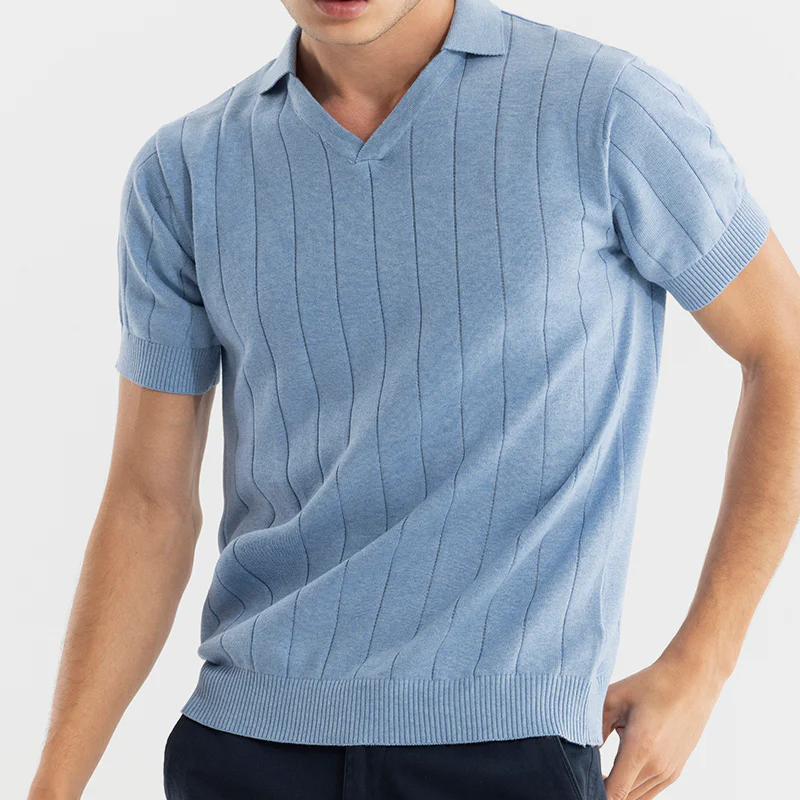

In [136]:
image

We have converted the image into black and white...

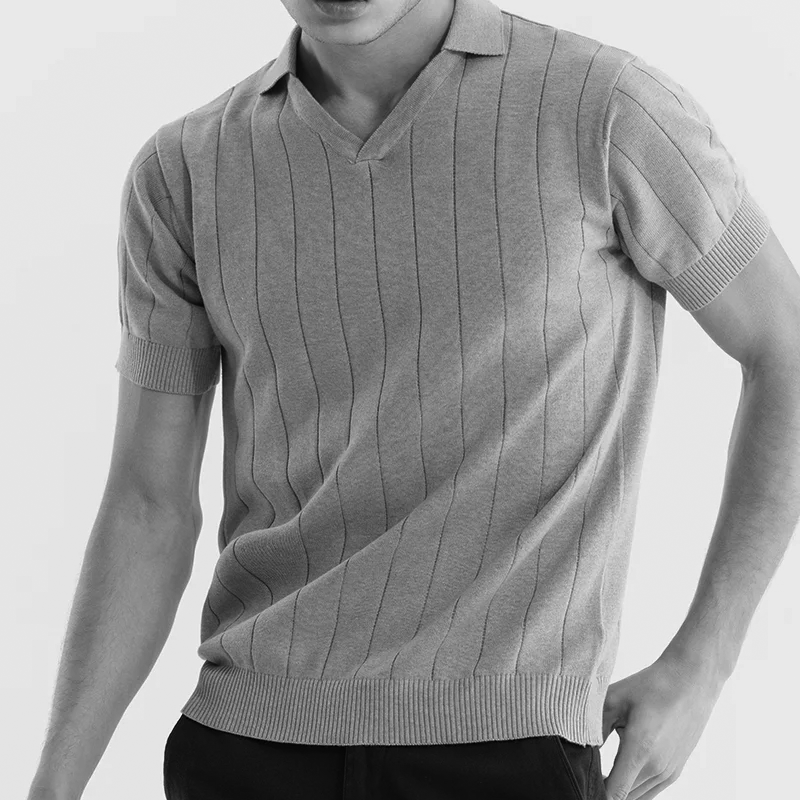

In [137]:
image = Image.open('../images/internet-tshirt-bw.png')  # Replace with your image path
image

In [138]:
from torchvision import transforms

image_resized = image.resize((28, 28))

transform = transforms.ToTensor()
image = transform(image)
image_resized = transform(image_resized)

In [139]:
#before
image.shape

torch.Size([1, 800, 800])

In [140]:
#after
image_resized.shape

torch.Size([1, 28, 28])

In [141]:
forward = image_resized.squeeze(0).reshape(1, -1)
forward.shape

torch.Size([1, 784])

In [142]:
prediction = torch.matmul(forward, weights) + bias
prediction_prob = softmax(prediction)

In [143]:
torch.argmax(prediction_prob)

tensor(9)

In [144]:
for i in range(10):
    print(i, data.text_labels([i]))

0 ['t-shirt']
1 ['trouser']
2 ['pullover']
3 ['dress']
4 ['coat']
5 ['sandal']
6 ['shirt']
7 ['sneaker']
8 ['bag']
9 ['ankle boot']


We... are... wrong here... damn.

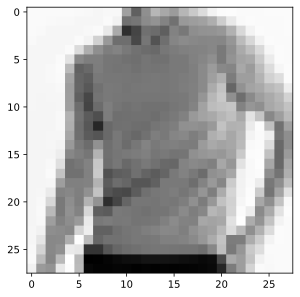

In [145]:
plt.imshow(image_resized.squeeze(0), cmap="gray");

- The above looks like ankle boot 😅 
- Let's try another one...

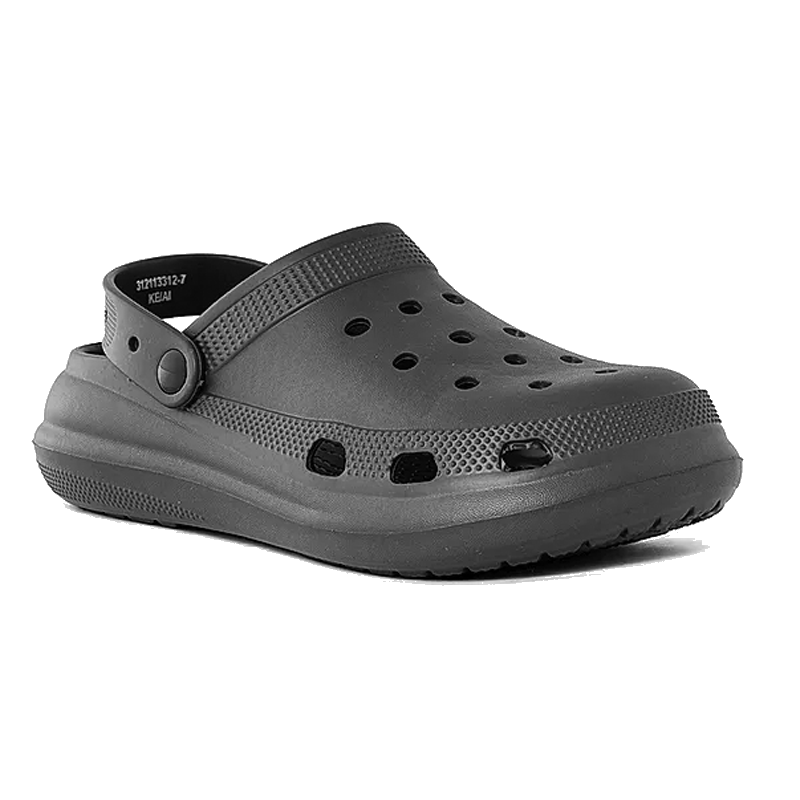

In [168]:
image = Image.open('../images/sandal.png')  # Replace with your image path
image

In [169]:
image_resized = image.resize((28, 28))
image_resized = transform(image_resized)
image_resized.shape

torch.Size([1, 28, 28])

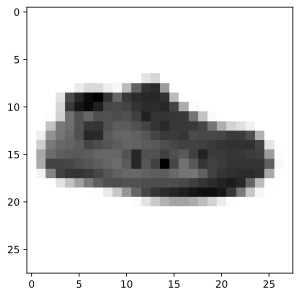

In [170]:
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [171]:
forward = image_resized.squeeze(0).reshape(1, -1)
prediction = torch.matmul(forward, weights) + bias
prediction_prob = softmax(prediction)
torch.argmax(prediction_prob)

tensor(6)

Not working. Nah

Let's try the image from data...

In [155]:
X, y = next(val_iter)

In [156]:
X[123].shape, y[123]

(torch.Size([1, 28, 28]), tensor(5))

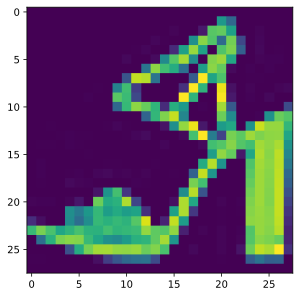

In [157]:
plt.imshow(X[123].squeeze(0));

In [158]:
forward = X[123].squeeze(0).reshape(1, -1)
prediction = torch.matmul(forward, weights) + bias
prediction_prob = softmax(prediction)
torch.argmax(prediction_prob)

tensor(5)

Correct!
I think... we need to deal with **the white background**. Let's make our image background white.

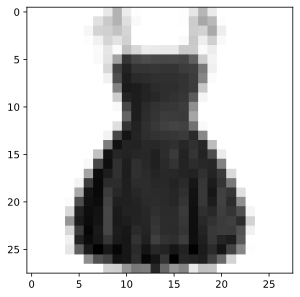

In [172]:
image = Image.open('../images/dress-clean.png')  # Replace with your image path
image_resized = image.resize((28, 28))
image_resized = transform(image_resized)
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [173]:
forward = image_resized.squeeze(0).reshape(1, -1)
prediction = torch.matmul(forward, weights) + bias
prediction_prob = softmax(prediction)
torch.argmax(prediction_prob)

tensor(8)

## 🔴

I think --- our testing environment data has different distribution than the ones in the original dataset. It works well in the validation... but not on the internet based data!

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960--1970s of statistical modeling.
In the next section, we will show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    1. Why do you think it runs more slowly?
    1. Should you use it? When would it make sense to?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


[Discussions](https://discuss.d2l.ai/t/51)
